<a href="https://colab.research.google.com/github/FrancisBacon95/ECG-Signal-Rhythm-type-Classifier/blob/main/03_Rhythm_Type_Classifier_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from collections import Counter, defaultdict
import math
import numpy as np
import plotly.express as px
import seaborn as sns
from scipy.stats import norm

In [31]:
data=pd.read_csv('final_data.csv')
data = pd.DataFrame(data)
data = data.sort_values('rhythm_type')
data = data.style.background_gradient(cmap='Reds')
data

FileNotFoundError: ignored

# 1. EDA

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
path='./gdrive/My Drive/Colab Notebooks/'
#path='./'
signal=pd.read_csv(path+'ecg.csv')
annotation=pd.read_csv(path+'ecg_pattern.csv')
del annotation["Unnamed: 0"]
display(signal)
display(annotation)

,'sample #','MLII','V1','V2','V4','V5',Name
0,0,995.0,NaN,NaN,NaN,1011.0,100
1,1,995.0,NaN,NaN,NaN,1011.0,100
2,2,995.0,NaN,NaN,NaN,1011.0,100
3,3,995.0,NaN,NaN,NaN,1011.0,100
4,4,995.0,NaN,NaN,NaN,1011.0,100
...,...,...,...,...,...,...,...
31199995,649995,946.0,1038.0,NaN,NaN,NaN,234
31199996,649996,946.0,1038.0,NaN,NaN,NaN,234
31199997,649997,945.0,1039.0,NaN,NaN,NaN,234
31199998,649998,948.0,1040.0,NaN,NaN,NaN,234


,Time,Sample,Type,Sub,Chan,Num,Aux,Name
0,0:00.050,18,+,0,0,0,(N,100
1,0:00.214,77,N,0,0,0,NaN,100
2,0:01.028,370,N,0,0,0,NaN,100
3,0:01.839,662,N,0,0,0,NaN,100
4,0:02.628,946,N,0,0,0,NaN,100
...,...,...,...,...,...,...,...,...
112642,30:02.214,648797,N,0,0,0,NaN,234
112643,30:02.889,649040,N,0,0,0,NaN,234
112644,30:03.589,649292,N,0,0,0,NaN,234
112645,30:04.267,649536,N,0,0,0,NaN,234


## 1-1) 리듬별 빈도수 확인

In [6]:
from collections import Counter
display(Counter(annotation["Aux"]))

target = ["(B", "(N", "(SVTA", "(VT"]
count = Counter( annotation["Aux"][ annotation["Aux"].isin(target) ] )
display(count)

Counter({'(AB': 3,
         '(AFIB': 107,
         '(AFL': 45,
         '(B': 221,
         '(BII': 5,
         '(IVR': 4,
         '(N': 530,
         '(NOD': 36,
         '(P': 60,
         '(PREX': 103,
         '(SBR': 1,
         '(SVTA': 26,
         '(T': 83,
         '(VFL': 6,
         '(VT': 61,
         'MISSB': 428,
         'PSE': 3,
         'TS': 6,
         nan: 110919})

Counter({'(B': 221, '(N': 530, '(SVTA': 26, '(VT': 61})

## 1-2) 환자별 타겟 리듬 관측도수, 비율 

In [7]:
name = signal["Name"].unique()
rhythm_by_person = pd.DataFrame(name,columns=['Name'])
#display(rhythm_by_person)

for i, n in enumerate(name):
    temp = annotation[annotation["Name"]==n]
    temp_count = Counter(temp["Aux"][ temp["Aux"].isin(target) ])

    rhythm_by_person.loc[i,"(N"] = int(temp_count["(N"])
    rhythm_by_person.loc[i,"(B"] = int(temp_count["(B"])
    rhythm_by_person.loc[i,"(SVTA"] = int(temp_count["(SVTA"])
    rhythm_by_person.loc[i,"(VT"] = int(temp_count["(VT"])
    
    total=int(temp_count["(N"]+temp_count["(B"]+temp_count["(SVTA"]+temp_count["(VT"])
    if total!=0:
        rhythm_by_person.loc[i,"(N rate"] = round(int(temp_count["(N"])/total,2)
        rhythm_by_person.loc[i,"(B rate"] = round(int(temp_count["(B"])/total,2)
        rhythm_by_person.loc[i,"(SVTA rate"] = round(int(temp_count["(SVTA"])/total,2)
        rhythm_by_person.loc[i,"(VT rate"] = round(int(temp_count["(VT"])/total,2)
rhythm_by_person

,Name,(N,(B,(SVTA,(VT,(N rate,(B rate,(SVTA rate,(VT rate
0,100,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
1,101,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
2,102,2.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
3,103,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
4,104,22.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
5,105,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
6,106,21.0,18.0,0.0,1.0,0.53,0.45,0.00,0.03
7,107,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,108,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
9,109,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00


# 1-3) 각 환자에서 발생하는  타겟 리듬의 최대 빈도수/비율

In [8]:
rhythm_by_person.iloc[:,1:].max()

(N            104.00
(B             71.00
(SVTA          10.00
(VT            21.00
(N rate         1.00
(B rate         0.90
(SVTA rate      0.48
(VT rate        1.00
dtype: float64

## 1-4) 각 타겟별 signal 수 확인

In [9]:
seIdx = []    # [count, strt_sample_Idx, end_sample_Idx, Name, rhythm_type]
idx = 0
for n in name:
    annotation_temp = annotation[annotation["Name"]==n]
    s=0
    for i, r in enumerate(annotation_temp["Aux"]):
        if(pd.isnull(r)==False):
            if(s!=0):
                n = annotation_temp["Name"].iloc[i]
                if(i==len(annotation_temp)-1):
                    e = max(signal["'sample #'"][signal["Name"]==n])
                else:
                    e = annotation_temp["Sample"].iloc[i-1]
                seIdx.append([(e-s)+1, s, e, n, t])
                s = 0
            if(r in target):
                t = annotation_temp["Aux"].iloc[i]
                s = annotation_temp["Sample"].iloc[i]
        else:
            if(s!=0):
                if(i==len(annotation_temp)-1):
                    n = annotation_temp["Name"].iloc[i]
                    e = max(signal[signal["Name"]==n]["'sample #'"])
                    seIdx.append([(e-s)+1, s, e, n, t])
            
seldx_pd=pd.DataFrame(seIdx, columns=['count', 'strt_sample_Idx', 'end_sample_Idx', 'Name', 'rhythm_type'])
seldx_pd

,count,strt_sample_Idx,end_sample_Idx,Name,rhythm_type
0,649982,18,649999,100,(N
1,649993,7,649999,101,(N
2,4926,29133,34058,102,(N
3,24144,38682,62825,102,(N
4,649979,21,649999,103,(N
...,...,...,...,...,...
832,1763,644479,646241,233,(B
833,3627,646373,649999,233,(N
834,304261,52,304312,234,(N
835,9093,304425,313517,234,(SVTA


## 1-5) 타겟 리듬별 크기 확인

In [10]:
from tqdm.notebook import tqdm

N = []
B = []
SVTA = []
VT = []
ecg_lst = []
name = signal["Name"].unique()
for nn in tqdm(name, desc='name'):
    ecg_temp = signal[signal["Name"]==nn]
    for c, s, e, n, t in tqdm(seIdx, desc='seIdx'):
        if(n!=nn): continue
        si = list(ecg_temp[ecg_temp["'sample #'"]==s].index)[0]
        ei = list(ecg_temp[ecg_temp["'sample #'"]==e].index)[0]
        if(n==102 | n==104):
            ecg_lst = list(ecg_temp["'V5'"].iloc[si:ei+1])
        else:
            ecg_lst = list(ecg_temp["'MLII'"].loc[si:ei+1])
        if(t=="(N"):
            N.append(ecg_lst)
        elif(t=="(B"):
            B.append(ecg_lst)
        elif(t=="(SVTA"):
            SVTA.append(ecg_lst)
        else:
            VT.append(ecg_lst)
            
N = pd.Series(N)
B = pd.Series(B)
SVTA = pd.Series(SVTA)
VT = pd.Series(VT)

In [11]:
rhythmLens_N = []
rhythmLens_B = []
rhythmLens_SVTA = []
rhythmLens_VT = []

for r in N:
    rhythmLens_N.append(len(r))
for r in B:
    rhythmLens_B.append(len(r))
for r in SVTA:
    rhythmLens_SVTA.append(len(r))
for r in VT:
    rhythmLens_VT.append(len(r))

### (1) N

Basic Statistics of (N
Num :  529
Mean :  42094.2381852552
Var :  14982242347.463116
Std :  122401.97035776473
Max :  649993
Min :  37
Median :  4208.0
25 Percentile :  1337.0
75 Percentile :  20812.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Dist. of (N')

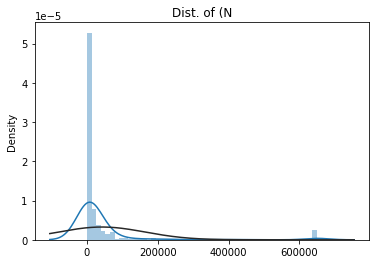

In [12]:
print("Basic Statistics of (N")
print("Num : ", len(rhythmLens_N))
print("Mean : ", np.mean(rhythmLens_N))
print("Var : ", np.var(rhythmLens_N))
print("Std : ", np.std(rhythmLens_N))
print("Max : " , np.max(rhythmLens_N))
print("Min : ", np.min(rhythmLens_N))
print("Median : ", np.median(rhythmLens_N))
print("25 Percentile : ", np.percentile(rhythmLens_N, 25))
print("75 Percentile : ", np.percentile(rhythmLens_N, 75))


fig = px.bar(x=range(len(rhythmLens_N)), y=sorted(rhythmLens_N))
fig.update_layout(title="Each sorted length of (N Rhythms",
                 yaxis_title="Length",)
fig.show()

sns.distplot(rhythmLens_N, fit=norm).set_title('Dist. of (N')

#Log 변환
#sns.distplot(np.log(rhythmLens_N), fit=norm).set_title('Dist. of Log("(N")')

### (2) B

Basic Statistics of (B
Num :  221
Mean :  3924.176470588235
Var :  52799745.367048174
Std :  7266.34332845952
Max :  53959
Min :  859
Median :  1480.0
25 Percentile :  1233.0
75 Percentile :  2794.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Dist. of (B')

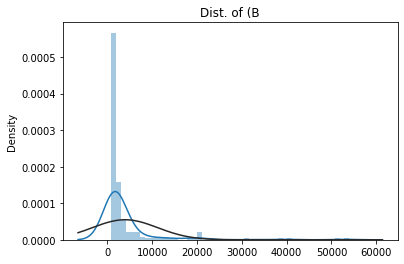

In [13]:
print("Basic Statistics of (B")
print("Num : ", len(rhythmLens_B))
print("Mean : ", np.mean(rhythmLens_B))
print("Var : ", np.var(rhythmLens_B))
print("Std : ", np.std(rhythmLens_B))
print("Max : " , np.max(rhythmLens_B))
print("Min : ", np.min(rhythmLens_B))
print("Median : ", np.median(rhythmLens_B))
print("25 Percentile : ", np.percentile(rhythmLens_B, 25))
print("75 Percentile : ", np.percentile(rhythmLens_B, 75))

fig = px.bar(x=range(len(rhythmLens_B)), y=sorted(rhythmLens_B))
fig.update_layout(title="Each length of (B Rhythms",
                 yaxis_title="Length",)
fig.show()

sns.distplot(rhythmLens_B, fit=norm).set_title('Dist. of (B')

### (3) SVTA

Basic Statistics of (SVTA
Num :  26
Mean :  2730.8076923076924
Var :  17846806.693786982
Std :  4224.548105275519
Max :  18639
Min :  353
Median :  671.5
25 Percentile :  482.25
75 Percentile :  2370.75


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Dist. of (SVTA')

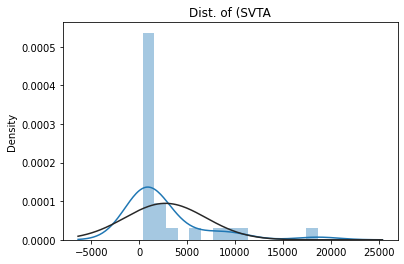

In [14]:
print("Basic Statistics of (SVTA")
print("Num : ", len(rhythmLens_SVTA))
print("Mean : ", np.mean(rhythmLens_SVTA))
print("Var : ", np.var(rhythmLens_SVTA))
print("Std : ", np.std(rhythmLens_SVTA))
print("Max : " , np.max(rhythmLens_SVTA))
print("Min : ", np.min(rhythmLens_SVTA))
print("Median : ", np.median(rhythmLens_SVTA))
print("25 Percentile : ", np.percentile(rhythmLens_SVTA, 25))
print("75 Percentile : ", np.percentile(rhythmLens_SVTA, 75))

fig = px.bar(x=range(len(rhythmLens_SVTA)), y=rhythmLens_SVTA)
fig.update_layout(title="Each length of (SVTA Rhythms",
                 yaxis_title="Length",)
fig.show()

sns.distplot(rhythmLens_SVTA, fit=norm).set_title('Dist. of (SVTA')

### (4) VT

Basic Statistics of (VT
Num :  61
Mean :  1076.2295081967213
Var :  8820634.340768611
Std :  2969.95527588693
Max :  19745
Min :  275
Median :  419.0
25 Percentile :  374.0
75 Percentile :  588.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Dist. of (VT')

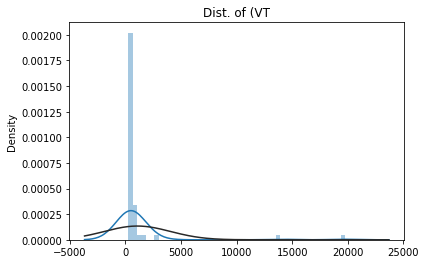

In [15]:
print("Basic Statistics of (VT")
print("Num : ", len(rhythmLens_VT))
print("Mean : ", np.mean(rhythmLens_VT))
print("Var : ", np.var(rhythmLens_VT))
print("Std : ", np.std(rhythmLens_VT))
print("Max : " , np.max(rhythmLens_VT))
print("Min : ", np.min(rhythmLens_VT))
print("Median : ", np.median(rhythmLens_VT))
print("25 Percentile : ", np.percentile(rhythmLens_VT, 25))
print("75 Percentile : ", np.percentile(rhythmLens_VT, 75))

fig = px.bar(x=range(len(rhythmLens_VT)), y=rhythmLens_VT)
fig.update_layout(title="Each length of (VT Rhythms",
                 yaxis_title="Length",)
fig.show()

sns.distplot(rhythmLens_VT, fit=norm).set_title('Dist. of (VT')

# 2. 리듬별 비트 타입 정보 추가

In [16]:
annotation_temp = annotation[annotation["Name"]==100]
annotation_temp

,Time,Sample,Type,Sub,Chan,Num,Aux,Name
0,0:00.050,18,+,0,0,0,(N,100
1,0:00.214,77,N,0,0,0,NaN,100
2,0:01.028,370,N,0,0,0,NaN,100
3,0:01.839,662,N,0,0,0,NaN,100
4,0:02.628,946,N,0,0,0,NaN,100
...,...,...,...,...,...,...,...,...
2269,30:02.717,648978,N,0,0,0,NaN,100
2270,30:03.422,649232,N,0,0,0,NaN,100
2271,30:04.122,649484,N,0,0,0,NaN,100
2272,30:04.817,649734,N,0,0,0,NaN,100


In [17]:
signal

,'sample #','MLII','V1','V2','V4','V5',Name
0,0,995.0,NaN,NaN,NaN,1011.0,100
1,1,995.0,NaN,NaN,NaN,1011.0,100
2,2,995.0,NaN,NaN,NaN,1011.0,100
3,3,995.0,NaN,NaN,NaN,1011.0,100
4,4,995.0,NaN,NaN,NaN,1011.0,100
...,...,...,...,...,...,...,...
31199995,649995,946.0,1038.0,NaN,NaN,NaN,234
31199996,649996,946.0,1038.0,NaN,NaN,NaN,234
31199997,649997,945.0,1039.0,NaN,NaN,NaN,234
31199998,649998,948.0,1040.0,NaN,NaN,NaN,234


In [18]:
from matplotlib import pyplot as plt
seIdx = []    # [count, strt_sample_Idx, end_sample_Idx, Name, rhythm_type, R_count, R_mean, R_count_per_beat]
beat_lst=[]
idx = 0
for n in name:
    annotation_temp = annotation[annotation["Name"]==n]
    s=0
    beat=defaultdict(int)
    for i, r in enumerate(annotation_temp["Aux"]):
        beat[annotation_temp.iloc[i,2]]+=1
        if(pd.isnull(r)==False):
            if(s!=0):
                n = annotation_temp["Name"].iloc[i]
                if(i==len(annotation_temp)-1):
                    e = max(signal["'sample #'"][signal["Name"]==n])
                else:
                    e = annotation_temp["Sample"].iloc[i-1]
                max_R=max(signal.iloc[s:e+1,1])
                R_lst=[signal.iloc[s,1],signal.iloc[e,1]]
                #plt.plot(range(len(signal[s+1:e])),signal[s+1:e])
                #plt.show()
                for j in range(len(signal[s+1:e])):
                    if signal.iloc[j,1]>=max_R*0.9 and signal.iloc[j,1]>signal.iloc[j-1,1] and signal.iloc[j,1]<signal.iloc[j+1,1]: 
                                R_lst.append(signal.iloc[j,1])
                R_cnt=len(R_lst)
                R_mean=sum(R_lst)/R_cnt
                R_cnt_per_beat=R_cnt/sum(list(beat.values()))
                R_cnt_per_sig=R_cnt/(e-s+1)
                seIdx.append([(e-s)+1, s, e, n, t,R_cnt,R_mean,R_cnt_per_beat,R_cnt_per_sig])
                #print([(e-s)+1, s, e, n, t,R_cnt,R_mean,R_cnt_per_beat,R_cnt_per_sig])
                s = 0
                beat_lst.append(list(beat.items()))
                beat=defaultdict(int)
            if(r in target):
                t = annotation_temp["Aux"].iloc[i]
                s = annotation_temp["Sample"].iloc[i]
        else:
            if(s!=0):
                if(i==len(annotation_temp)-1):
                    n = annotation_temp["Name"].iloc[i]
                    e = max(signal[signal["Name"]==n]["'sample #'"])
                    max_R=max(signal.iloc[s:e+1,1])
                    R_lst=[signal.iloc[s,1],signal.iloc[e,1]]
                    #plt.plot(range(len(signal[s+1:e])),signal[s+1:e])
                    #plt.show()
                    for j in range(len(signal[s+1:e])):
                        if signal.iloc[j,1]>=max_R*0.9 and signal.iloc[j,1]>signal.iloc[j-1,1] and signal.iloc[j,1]<signal.iloc[j+1,1]: 
                                    R_lst.append(signal.iloc[j,1])
                    R_cnt=len(R_lst)
                    R_mean=sum(R_lst)/R_cnt
                    R_cnt_per_beat=R_cnt/sum(list(beat.values()))
                    R_cnt_per_sig=R_cnt/(e-s+1)
                    seIdx.append([(e-s)+1, s, e, n, t,R_cnt,R_mean,R_cnt_per_beat,R_cnt_per_sig])
                    #print([(e-s)+1, s, e, n, t,R_cnt,R_mean,R_cnt_per_beat,R_cnt_per_sig])
                    beat_lst.append(list(beat.items()))
                    beat=defaultdict(int)
seldx_pd=pd.DataFrame(seIdx, columns=['count', 'strt_sample_Idx', 'end_sample_Idx', 'Name', 'rhythm_type', 'R_count', 'R_mean', 'R_count_per_beat','R_count_per_sig'])
seldx_pd

,count,strt_sample_Idx,end_sample_Idx,Name,rhythm_type,R_count,R_mean,R_count_per_beat,R_count_per_sig
0,649982,18,649999,100,(N,3081,1210.749107,1.354881,0.004740
1,649993,7,649999,101,(N,3082,1210.743673,1.644610,0.004742
2,4926,29133,34058,102,(N,38,1157.473684,0.319328,0.007714
3,24144,38682,62825,102,(N,227,1158.242291,2.247525,0.009402
4,649979,21,649999,103,(N,3081,1210.748458,1.473458,0.004740
...,...,...,...,...,...,...,...,...,...
832,1763,644479,646241,233,(B,15,1137.800000,1.500000,0.008508
833,3627,646373,649999,233,(N,22,1149.500000,1.294118,0.006066
834,304261,52,304312,234,(N,1699,1188.507357,1.303914,0.005584
835,9093,304425,313517,234,(SVTA,64,1168.593750,1.254902,0.007038


In [19]:
beat_type_cols=set()
for item in beat_lst:
    for jtem in item:
        beat_type_cols.add(jtem[0])
beat_type_cols=list(beat_type_cols)
beat_type_cols.append('total_beat')
beat_type_pd=pd.DataFrame(columns=list(beat_type_cols))

display(beat_lst)
for i, row in enumerate(beat_lst):
    tmp_row=[0]*len(beat_type_cols)
    type_cnt=len(row)
    for j in range(type_cnt):
        if row[j][0] in beat_type_cols:
            tmp_row[beat_type_cols.index(row[j][0])] = row[j][1]
            tmp_row[-1] += row[j][1]
    if tmp_row[-1]!=0:
        for jj in range(len(tmp_row[:-1])):
            tmp_row[jj]=round(tmp_row[jj]/tmp_row[-1],2)
    beat_type_pd.loc[i] = tmp_row
    
data = pd.concat([seldx_pd, beat_type_pd],axis=1)
data

[[('+', 1), ('N', 2239), ('A', 33), ('V', 1)],
 [('+', 1), ('N', 1860), ('~', 4), ('|', 4), ('Q', 2), ('A', 3)],
 [('+', 3), ('/', 92), ('f', 6), ('N', 17), ('V', 1)],
 [('/', 6), ('f', 12), ('+', 2), ('N', 81)],
 [('+', 1), ('N', 2082), ('~', 6), ('A', 2)],
 [('+', 3), ('/', 55), ('f', 22), ('~', 3), ('Q', 3)],
 [('/', 22), ('~', 1), ('f', 10), ('N', 3), ('+', 2)],
 [('/', 49), ('N', 9), ('f', 20), ('~', 4), ('+', 2)],
 [('/', 8), ('~', 2), ('+', 2), ('N', 2), ('f', 2)],
 [('/', 14), ('~', 4), ('f', 6), ('N', 3), ('+', 2)],
 [('/', 11), ('~', 7), ('+', 2), ('N', 23), ('f', 19), ('Q', 2), ('V', 1)],
 [('/', 38), ('f', 38), ('~', 8), ('N', 26), ('+', 2), ('Q', 13)],
 [('f', 49), ('/', 41), ('~', 6), ('+', 2), ('N', 17)],
 [('/', 16), ('+', 2), ('N', 2), ('f', 13)],
 [('/', 9), ('+', 2), ('N', 2), ('f', 5)],
 [('/', 24), ('f', 21), ('N', 3), ('+', 2)],
 [('/', 12), ('+', 2), ('N', 2), ('f', 8)],
 [('/', 10), ('~', 2), ('+', 2), ('N', 2), ('f', 7)],
 [('/', 20), ('f', 12), ('N', 3), ('+',

,count,strt_sample_Idx,end_sample_Idx,Name,rhythm_type,R_count,R_mean,R_count_per_beat,R_count_per_sig,[,F,],V,!,J,+,e,Q,/,L,A,R,f,a,"""",N,E,|,x,~,j,S,total_beat
0,649982,18,649999,100,(N,3081,1210.749107,1.354881,0.004740,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.0,0.0,0.98,0.0,0.0,0.0,0.0,0.0,0.0,2274.0
1,649993,7,649999,101,(N,3082,1210.743673,1.644610,0.004742,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.99,0.0,0.0,0.0,0.0,0.0,0.0,1874.0
2,4926,29133,34058,102,(N,38,1157.473684,0.319328,0.007714,0.0,0.0,0.0,0.01,0.0,0.00,0.03,0.0,0.0,0.77,0.0,0.00,0.0,0.05,0.0,0.0,0.14,0.0,0.0,0.0,0.0,0.0,0.0,119.0
3,24144,38682,62825,102,(N,227,1158.242291,2.247525,0.009402,0.0,0.0,0.0,0.00,0.0,0.00,0.02,0.0,0.0,0.06,0.0,0.00,0.0,0.12,0.0,0.0,0.80,0.0,0.0,0.0,0.0,0.0,0.0,101.0
4,649979,21,649999,103,(N,3081,1210.748458,1.473458,0.004740,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,2091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,1763,644479,646241,233,(B,15,1137.800000,1.500000,0.008508,0.0,0.0,0.0,0.50,0.0,0.00,0.10,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.40,0.0,0.0,0.0,0.0,0.0,0.0,10.0
833,3627,646373,649999,233,(N,22,1149.500000,1.294118,0.006066,0.0,0.0,0.0,0.18,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.82,0.0,0.0,0.0,0.0,0.0,0.0,17.0
834,304261,52,304312,234,(N,1699,1188.507357,1.303914,0.005584,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,1303.0
835,9093,304425,313517,234,(SVTA,64,1168.593750,1.254902,0.007038,0.0,0.0,0.0,0.00,0.0,0.98,0.02,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,51.0


In [20]:
del data['Name']
del data['strt_sample_Idx']
del data['end_sample_Idx']

# 3. 차원축소
## 3-1. PCA: 결과 좋지 않음.
## 3-2. PCA 기반으로 t-SNE: 결과 좋지 않음.

### N을 제외하고 봤을 땐, 2차원임에도 어느정도 군집화가 된 것을 확인할 수 있다.
### 확인을 위함이다. 특징을 알 수 없기에 모델에 사용하지 않을 것이다.


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x = data.drop(['rhythm_type'], axis=1).values # 독립변인들의 value값만 추출
y = data['rhythm_type'].values # 종속변인 추출

x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장
features=list(data.columns)
features.remove('rhythm_type')
pd.DataFrame(x, columns=features)

pca=PCA(n_components=len(features)-1)
pca_fit=pca.fit(x)
print('Explain Variance Ratio : \n', np.round_(pca.explained_variance_ratio_,2))

print('\n\nSingular value: \n', pca.singular_values_)
#print('\n\nSingular vector: \n', pca.components_.T)
#print('\n\nExplain Standard Deviation: \n', np.round_(np.sqrt(pca.explained_variance_)))
#print('\n\nNoise Variance: \n', pca.noise_variance_)

Explain Variance Ratio : 
 [0.13 0.08 0.07 0.06 0.06 0.05 0.04 0.04 0.04 0.04 0.04 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.02 0.02 0.02 0.01 0.   0.   0.   0.  ]


Singular value: 
 [55.54658815 43.54243338 41.01196416 39.1827972  37.17134958 34.25626823
 32.95254942 31.09429963 30.88867531 29.86655317 29.47274993 29.09748327
 28.91086442 28.71305696 28.18798688 27.83222297 27.1072374  26.47991554
 26.27032139 25.89913241 24.45363924 21.56162168 21.29021886 12.76578423
  9.58769823  7.35392641  6.99549275  2.12010241]


In [22]:
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.80) + 1 # 분산의 설명량이 95%이상 되는 차원의 수
display(num_d)
pca = PCA(n_components=0.80) #95%이상의 분산을 설명력을 갖는 차원축소
new_pca_fit = pca.fit_transform(x)
new_pca_fit_pd= pd.DataFrame(new_pca_fit)

16

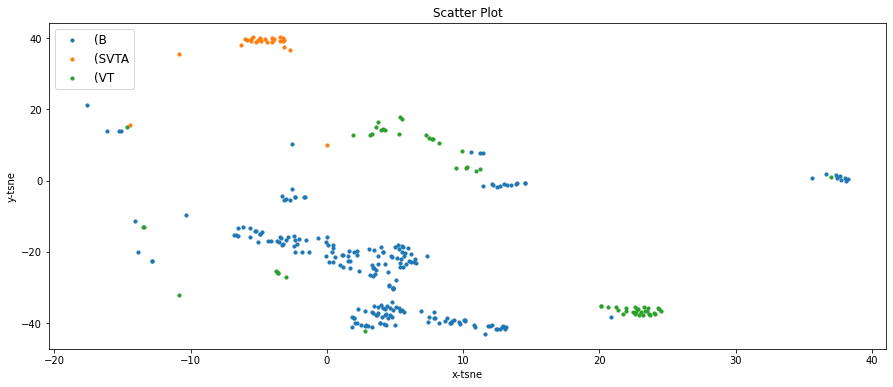

In [23]:
# Perform the necessary imports
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(new_pca_fit)

df_tsne = pd.concat([new_pca_fit_pd,data['rhythm_type']],axis=1)
df_tsne['x_tsne'] = tsne_results[:,0]
df_tsne['y_tsne'] = tsne_results[:,1]

fig = px.scatter(df_tsne, x="x_tsne", y="y_tsne", color="rhythm_type")
fig.show()

groups= df_tsne.groupby('rhythm_type')
fig, ax = plt.subplots(figsize=(15, 6))
for rhythm, group in groups:
    if rhythm != "(N":
        ax.scatter(group.x_tsne, group.y_tsne, label=rhythm, s=10)
ax.legend(fontsize=12, loc='upper left') # legend position

plt.title('Scatter Plot')
plt.xlabel('x-tsne')
plt.ylabel('y-tsne')
plt.show()

#### (N을 제외하면 어느정도 나눠지는 것처럼 보인다.

# 모델링(Random Forest)

데이터가 적기 때문에 오버피팅 가능성을 고려하여 배깅 이용
-> Randon Forest


In [24]:
data

,count,rhythm_type,R_count,R_mean,R_count_per_beat,R_count_per_sig,[,F,],V,!,J,+,e,Q,/,L,A,R,f,a,"""",N,E,|,x,~,j,S,total_beat
0,649982,(N,3081,1210.749107,1.354881,0.004740,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.0,0.0,0.98,0.0,0.0,0.0,0.0,0.0,0.0,2274.0
1,649993,(N,3082,1210.743673,1.644610,0.004742,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.99,0.0,0.0,0.0,0.0,0.0,0.0,1874.0
2,4926,(N,38,1157.473684,0.319328,0.007714,0.0,0.0,0.0,0.01,0.0,0.00,0.03,0.0,0.0,0.77,0.0,0.00,0.0,0.05,0.0,0.0,0.14,0.0,0.0,0.0,0.0,0.0,0.0,119.0
3,24144,(N,227,1158.242291,2.247525,0.009402,0.0,0.0,0.0,0.00,0.0,0.00,0.02,0.0,0.0,0.06,0.0,0.00,0.0,0.12,0.0,0.0,0.80,0.0,0.0,0.0,0.0,0.0,0.0,101.0
4,649979,(N,3081,1210.748458,1.473458,0.004740,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,2091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,1763,(B,15,1137.800000,1.500000,0.008508,0.0,0.0,0.0,0.50,0.0,0.00,0.10,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.40,0.0,0.0,0.0,0.0,0.0,0.0,10.0
833,3627,(N,22,1149.500000,1.294118,0.006066,0.0,0.0,0.0,0.18,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.82,0.0,0.0,0.0,0.0,0.0,0.0,17.0
834,304261,(N,1699,1188.507357,1.303914,0.005584,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,1303.0
835,9093,(SVTA,64,1168.593750,1.254902,0.007038,0.0,0.0,0.0,0.00,0.0,0.98,0.02,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,51.0


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score

y=data['rhythm_type']
x = data.drop(['rhythm_type'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=880818)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)

predicted=rf.predict(x_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score: {accuracy:.3}')
f1_score = f1_score(y_test, predicted,average='weighted')
print(f'Mean f1-score score: {f1_score:.3}')

cnf_matrix=confusion_matrix(y_test, predicted)
print(cnf_matrix)

Mean accuracy score: 0.972
Mean f1-score score: 0.972
[[ 62   4   0   1]
 [  0 159   0   0]
 [  0   1   6   1]
 [  0   0   0  18]]


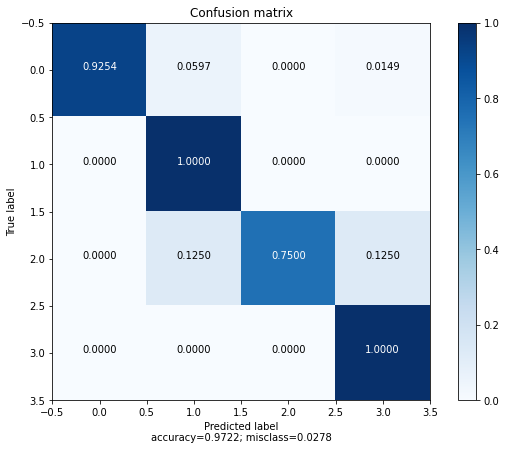

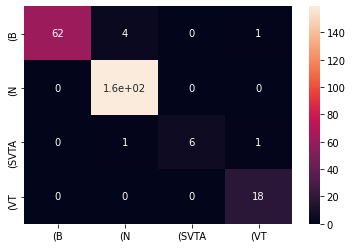

In [38]:
import itertools

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(cnf_matrix, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix')

cm = pd.DataFrame(cnf_matrix, columns=['(B','(N','(SVTA','(VT'], index=['(B','(N','(SVTA','(VT'])
sns.heatmap(cm, annot=True)

In [39]:
from sklearn import tree
import graphviz

In [42]:
# 의사결정나무 분류 
clf = tree.DecisionTreeClassifier(max_depth = 5)               # 종속변수가 현재 범주형
clf = clf.fit(x_train, y_train)             # feature, target
# 시각화
dot_data = tree.export_graphviz(clf,   # 의사결정나무 모형 대입
                               out_file = None,  # file로 변환할 것인가
                               feature_names =x.columns,  # feature 이름
                               class_names = ['(B','(N','(SVTA','(VT'],  # target 이름
                               filled = True,           # 그림에 색상을 넣을것인가
                               rounded = True,          # 반올림을 진행할 것인가
                               special_characters = True)   # 특수문자를 사용하나

graph = graphviz.Source(dot_data)

print(graph)
print(confusion_matrix(y_test, clf.predict(x_test)))
accuracy = accuracy_score(y_test, clf.predict(x_test))
print(f'Mean accuracy score: {accuracy:.3}')
precision = precision_score(y_test, clf.predict(x_test), average='weighted')
recall = recall_score(y_test, clf.predict(x_test), average='weighted')
f1_score = 2/(1/precision+1/recall)
print(f'Mean f1-score score: {f1_score:.3}')
graph.format = "png"
graph.render("DecisionTree")

[[ 62   4   0   1]
 [  1 158   0   0]
 [  0   2   6   0]
 [  0   1   0  17]]
Mean accuracy score: 0.964
Mean f1-score score: 0.965


'DecisionTree.png'

,count,R_count,R_mean,R_count_per_beat,R_count_per_sig,[,F,],V,!,J,+,e,Q,/,L,A,R,f,a,"""",N,E,|,x,~,j,S,total_beat
0,649982,3081,1210.749107,1.354881,0.004740,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.0,0.0,0.98,0.0,0.0,0.0,0.0,0.0,0.0,2274.0
1,649993,3082,1210.743673,1.644610,0.004742,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.99,0.0,0.0,0.0,0.0,0.0,0.0,1874.0
2,4926,38,1157.473684,0.319328,0.007714,0.0,0.0,0.0,0.01,0.0,0.00,0.03,0.0,0.0,0.77,0.0,0.00,0.0,0.05,0.0,0.0,0.14,0.0,0.0,0.0,0.0,0.0,0.0,119.0
3,24144,227,1158.242291,2.247525,0.009402,0.0,0.0,0.0,0.00,0.0,0.00,0.02,0.0,0.0,0.06,0.0,0.00,0.0,0.12,0.0,0.0,0.80,0.0,0.0,0.0,0.0,0.0,0.0,101.0
4,649979,3081,1210.748458,1.473458,0.004740,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,2091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,1763,15,1137.800000,1.500000,0.008508,0.0,0.0,0.0,0.50,0.0,0.00,0.10,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.40,0.0,0.0,0.0,0.0,0.0,0.0,10.0
833,3627,22,1149.500000,1.294118,0.006066,0.0,0.0,0.0,0.18,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.82,0.0,0.0,0.0,0.0,0.0,0.0,17.0
834,304261,1699,1188.507357,1.303914,0.005584,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,1303.0
835,9093,64,1168.593750,1.254902,0.007038,0.0,0.0,0.0,0.00,0.0,0.98,0.02,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,51.0


In [41]:
def network(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape),name='inputs_cnn')
    
    #conv. layer 1
    conv1_1=Convolution1D(64,(3),activation="relu",input_shape=im_shape)(inputs_cnn)
    conv1_2=BatchNormalization()(conv1_1)
    #conv. layer 2
    conv2_1=Convolution1D(64,(3),activation="relu",input_shape=im_shape)(conv1_1)
    conv2_2=BatchNormalization()(conv2_1)
    
    #pooling layer 1
    pool1=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv2_2)
    
    #conv. layer 3
    conv3_1=Convolution1D(128,(3),activation="relu",input_shape=im_shape)(pool1)
    conv3_2=BatchNormalization()(conv3_1)
    #conv. layer 4
    conv4_1=Convolution1D(128,(3),activation="relu",input_shape=im_shape)(conv3_2)
    conv4_2=BatchNormalization()(conv4_1)
    
    #pooling layer 2
    pool2=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv4_2)
    
    #conv. layer 5
    conv5_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(pool2)
    conv5_2=BatchNormalization()(conv5_1)
    #conv. layer 6
    conv6_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv5_2)
    conv6_2=BatchNormalization()(conv6_1)
    #conv. layer 7
    conv7_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv6_2)
    conv7_2=BatchNormalization()(conv7_1)
    
    #pooling layer 3
    pool3=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv7_2)
    
    
    #conv. layer 8
    conv8_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(pool3)
    conv8_2=BatchNormalization()(conv8_1)
    #conv. layer 9
    conv9_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv8_2)
    conv9_2=BatchNormalization()(conv9_1)
    #conv. layer 10
    conv10_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv9_2)
    conv10_2=BatchNormalization()(conv10_1)
    
    #pooling layer 4
    pool4=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv10_2)
    
    #conv. layer 11
    conv11_1=Convolution1D(512,(3),activation="relu",input_shape=im_shape)(pool4)
    conv11_2=BatchNormalization()(conv11_1)
    #conv. layer 12
    conv12_1=Convolution1D(512,(3),activation="relu",input_shape=im_shape)(conv11_2)
    conv12_2=BatchNormalization()(conv12_1)
    #conv. layer 13
    conv13_1=Convolution1D(512,(3),activation="relu",input_shape=im_shape)(conv12_2)
    conv13_2=BatchNormalization()(conv13_1)
    
    #pooling layer 5
    pool5=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv13_2)
    
    #flattened layer 1
    flatten=Flatten()(pool3)
    #dense layers
    # Dense(1000)의 의미는 1000개의 hidden unit을 가지는 fully connected layer
    dense_end1=Dense(1000,activation='relu')(flatten)
    dense_end2=Dense(1000,activation='relu')(dense_end1)
    #output layers
    main_output=Dense(6,activation='softmax',name='main_output')(dense_end1)
    
    model=Model(inputs=inputs_cnn,outputs=main_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy', precision, recall, f1score])
    
    callbacks=[EarlyStopping(monitor='val_loss',patience=2),
              ModelCheckpoint(filepath='best_model.h5',monitor='val_loss',save_best_only=True)]
    
    history=model.fit(x_train, y_train, epochs=10, callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('best_model.h5')
    return (model, history)